In [1]:
# -*- coding: utf-8 -*-
"""
@author: Etienne Kras
"""

# generic imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import time
import geemap
import geojson
import ee
ee.Initialize()

# specific imports
from typing import Any, Dict, List, Optional
from geojson import Polygon, Feature, FeatureCollection, dump
from shapely.geometry import Polygon
from dateutil.relativedelta import *
from google.cloud import storage
from logging import Logger, getLogger
from googleapiclient.discovery import build
from re import sub
from ctypes import ArgumentError
from functools import partial
from dateutil.parser import parse

# custom functionality import without requirement to pip install package
local_path = r"C:\Users\kras\GitHub\ee-packages-py"  # path to local GitHub clone
sys.path.append(local_path)
from eepackages.applications.bathymetry import Bathymetry
from eepackages import tiler

logger: Logger = getLogger(__name__)


TODO (wishlist):

grid cell image collection
- image clipped on tile & obtain centroid
- cloud-mask with QA60?
- calculate proportion of coverge on tile
- time of acquisition in featurecollection metadata

tidal calibration (TODO!)
- load in GTSM info and match centriod with closest point / linear interpolation
- derive MHWS and MLWS (in m) relative to MSL
- get tidal elevation relative to MSL at time of acq. from GTSM
- convert to percentage by combining tidal elev, MHWS & MLWS
- obtain high tide & low tide offset and spread (diff. high & low tide)
- potentially get in-situ gauge data in certain cells (if applicable)

water occurrence
- calculate NDWI for each image in grid
- Use 0.2 or otsu to determine water / land area. Water is 1 and land is 0
- calculate water occurrence freq (perc) for all images in the collection

intertidal elevation & tidal stage
- creation of median images at set bins by means of water occurrence
- identify lower value of tidal stage in each bin & the mean tidal elevation
- create intertidal elevation from all images
- create tidal stage from all image

viewing application
- water occurrence output
- intertidal elevation output
- intertidal tide stage output
- true color image of highest tidal stage
- ture color image of lowest tidal stage
- MHWS & MLWS contours (vectors)

TODO: implement migration to NETCDF4 with WGS84 non projected lon lat relative to MSL

TODO: validate the output on in-situ data

# Project specific toggles

In [2]:
# see scheme at https://github.com/openearth/eo-bathymetry/blob/master/notebooks/rws-bathymetry/acces_api.pdf for a workflow visualization 

# project toggles
main_fol = r"p:\11209821-cmems-global-sdb" # name of the main local folder 
bucket = "cmems-sdb" # name of the Google Cloud Storage bucket to store files in the cloud
credential_file = r"p:\11209821-cmems-global-sdb\00_miscellaneous\KEYS\bathymetry-543b622ddce7.json" # Cloud Storage credential key
output_fol = "Proxy" # name of the overall project
project_name = "AOI_GER_WaddenSea" # name of the project AoI
draw_AoI = 0 # toggle 1 to draw AoI, 0 to load

# composite image toggles
mode = "intertidal" # specify mode, either "intertidal" or "subtidal"
start_date = "2021-01-01" # start date of the composites
stop_date = "2022-01-01" # end date of the composites
compo_int = 12 # composite interval [months]
compo_len = 12 # composite length [months]
scale = 30  # output resolution of the image [m]

# tiling options
zoomed_list = [9, 10, 11] # list with zoom levels to be inspected
sel_tile = 2 # idx of chosen tile level in zoomed_list (inspect the map to chose it accordingly), z9 too big for in memory computations
# note, see https://www.openearth.nl/rws-bathymetry/2019.html; Z9 is optimal size..

# load google credentials, if specified
if not credential_file == "":  
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(credential_file)

# Pre-processing using the API

In [3]:
# draw or load Area of Interest (AoI)

# TODO: take center of AOI input file if present, put in random coordinate and let user find a place and draw a polygon
# TODO: fix horizontal tiling error (DOS) in API (to use multiple tiles) or move to single polygon run if AoI crosses multiple tiles
Map = geemap.Map(center=(54.2, 6.7), zoom=8) # initialize map with base in Hudayriat

if draw_AoI == 1:
    print("Please draw a polygon somewhere in a water body") # identifier
if draw_AoI == 0:
    # open AoI
    print("Loading and visualizing AoI") #identifier
    #AoIee = geemap.geojson_to_ee(os.path.join(main_fol,'AOI',project_name+'.geojson'))

    with open(os.path.join(main_fol, "00_miscellaneous\AOIs", project_name + ".geojson"), 'r') as f:
        contents = geojson.loads(f.read())
    AoIee = ee.Geometry(contents["features"][0]["geometry"])

    Map.addLayer(AoIee, {}, "AoI")

Map # show map

Loading and visualizing AoI


Map(center=[54.2, 6.7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(…

In [4]:
# (re)construct the AoI

if draw_AoI == 1:
    
    print("Constructing AoI from drawn polygon") # identifier
    
    # get AoI 
    AoIee = ee.FeatureCollection(Map.draw_features) # make featurecollection
    AoI = Polygon(AoIee.getInfo()["features"][0]["geometry"]["coordinates"][0]) # create AoI shapefile

    # export AoI
    features = []
    features.append(Feature(geometry=AoI, properties={"AoI": project_name}))
    feature_collection = FeatureCollection(features)
    with open(os.path.join(main_fol,"AOI",project_name + ".geojson"), "w") as f: # geojson
        dump(feature_collection, f)
    gdr = gpd.GeoDataFrame({"properties":{"AoI": project_name}, "geometry": AoI}, crs="EPSG:4326") #shp
    gdr.to_file(os.path.join(main_fol,"AOI",project_name+".shp"))
    bounds = ee.Geometry.Polygon([[[a,b] for a, b in zip(*AoI.exterior.coords.xy)]])
    
if draw_AoI == 0:
    print("Reconstructing AoI from loaded file")
    # get AoI
    with open(os.path.join(main_fol,"00_miscellaneous\AOIs",project_name+".geojson")) as f:
        AoIjson = geojson.load(f)
    # try: # drawn polygon in this script
    #     AoI = Polygon(AoIjson["features"][0]["geometry"]["coordinates"]) 
    # except: # drawn in QGIS / ArcGIS and written to geojson there (client file)
    #     AoI = Polygon(AoIjson["features"][0]["geometry"]["coordinates"][0])
    #bounds = ee.Geometry.Polygon([[[a,b] for a, b in zip(*AoI.exterior.coords.xy)]])
    bounds = ee.Geometry.MultiPolygon(AoIjson["features"][0]["geometry"]["coordinates"])

Reconstructing AoI from loaded file


In [5]:
# tiling the AoI
def add_tile_bounds(zoom):
    tiled = tiler.get_tiles_for_geometry(bounds, zoom)
    Map.addLayer(tiled.style(width=max(1, 10 - zoom), fillColor= "00000022"), {}, "tiles " + str(zoom))

    return(tiled)

tiles = list(map(add_tile_bounds, zoomed_list)) # add tiles for different zoom levels

In [6]:
# Get the bounds of the AoI
# print('Bounds')
# bounds = ee.Geometry(AoIjson["features"][0]["geometry"])

# Get the tiles for the AoI
print('Tiles')
tiles = list(tiler.get_tiles_for_geometry(bounds, zoom) for zoom in zoomed_list)

Tiles


In [7]:
# export selected tiles (represented by zoom level) to geojsons
# note, adjust sel_tile accordingly 
# for idx, tile in enumerate(tiles[sel_tile].getInfo()["features"]):
#     tile_pol = Polygon(tile['geometry']['coordinates'][0]) # create tile polygon
#     tile_name = "z%s_x%s_y%s"%(tile["properties"]["zoom"], int(float(tile["properties"]["tx"])), int(float(tile["properties"]["ty"])))

#     features = []
#     features.append(Feature(geometry=tile_pol, properties={"name": tile_name}))
#     feature_collection = FeatureCollection(features)
#     feature_collection.crs = {"type": "name","properties": {"name": "epsg:3857"}} # default EE projection
#     with open(os.path.join(main_fol,"00_miscellaneous\AOI_polygons",tile_name + ".geojson"), "w") as f: # geojson
#         dump(feature_collection, f)

# Compute SDB using the API

In [8]:
tiled = tiles[sel_tile]
tile = ee.Feature(tiled.filterMetadata("tx", "equals", "1065.0").filterMetadata("ty", "equals", "660.0").first())

In [9]:
# Get start and stop dates
start=ee.String(start_date)
stop=ee.String(stop_date)

bounds: ee.Geometry = ee.Feature(tile).geometry().bounds(1)
sdb: Bathymetry = Bathymetry()
zoom: ee.String = ee.String(tile.get("zoom"))
tx: ee.String = ee.String(tile.get("tx"))
ty: ee.String = ee.String(tile.get("ty"))
tile_name: ee.String = ee.String("z").cat(zoom).cat("_x").cat(tx).cat("_y").cat(ty).replace("\.\d+", "", "g")
img_fullname: ee.String = ee.String(tile_name).cat("_t").cat(ee.Date(start).millis().format())
    
image: ee.Image = sdb.compute_intertidal_depth(
    bounds=bounds,
    start=start,
    stop=stop,
    scale=tiler.zoom_to_scale(ee.Number.parse(tile.get("zoom"))).multiply(5), # scale to search for clean images
    # missions=['S2', 'L8'],
    # filter: ee.Filter.dayOfYear(7*30, 9*30), # summer-only
    filter_masked=False, 
    # filterMaskedFraction = 0.5,
    # skip_scene_boundary_fix=False,
    # skip_neighborhood_search=False,
    neighborhood_search_parameters={"erosion": 0, "dilation": 0, "weight": 50},
    bounds_buffer=0,
    water_index_min=-0.05,
    water_index_max=0.15,
    # lowerCdfBoundary=45,
    # upperCdfBoundary=50,
    # cloud_frequency_threshold_data=0.15, 
    clip = True
)# .reproject(ee.Projection("EPSG:3857").atScale(90))

image = image.set(
    "fullname", img_fullname,
    "system:time_start", ee.Date(start).millis(),
    "system:time_stop", ee.Date(stop).millis(),
    "zoom", zoom,
    "tx", tx,
    "ty", ty
)

# TODO: understand the CDFquality score weighting 


In [10]:
# Get dates of all images
ee_dates = sdb._raw_images.aggregate_array("system:time_start").map(lambda date: ee.Date(date).format("YYYY-MM-dd HH:mm:ss"))
dates = ee_dates.getInfo()
print(dates)

['2021-05-12 10:46:06', '2021-05-12 10:46:07', '2021-05-31 10:33:11', '2021-10-04 10:46:07', '2021-10-04 10:46:07', '2021-04-20 10:55:58', '2021-04-20 10:55:58', '2021-05-31 10:32:47', '2021-08-10 10:46:09', '2021-08-23 10:56:06', '2021-08-10 10:46:10', '2021-08-23 10:56:05', '2021-06-01 10:46:08', '2021-07-18 10:33:23', '2021-06-01 10:46:08', '2021-04-27 10:46:03', '2021-03-05 10:27:13', '2021-06-09 10:27:04', '2021-04-27 10:46:02', '2021-03-31 10:56:02', '2021-03-31 10:56:02', '2021-07-18 10:32:59', '2021-03-16 10:56:03', '2021-03-16 10:56:03', '2021-06-09 10:56:04', '2021-02-26 10:46:05', '2021-10-24 10:46:08', '2021-10-24 10:46:09', '2021-02-26 10:46:06', '2021-06-09 10:56:05', '2021-06-16 10:46:08', '2021-06-16 10:46:08', '2021-07-24 10:56:07', '2021-07-24 10:56:07', '2021-06-16 10:33:17', '2021-04-25 10:56:00', '2021-09-09 10:46:07', '2021-06-16 10:32:54', '2021-07-11 10:27:11', '2021-09-09 10:46:07', '2021-10-12 10:56:09', '2021-10-12 10:56:09', '2021-04-25 10:56:00', '2021-02-1

In [11]:
len(dates)

101

In [12]:
def NDWI(image):
	""" Calculates the NDWI of an image
	:param image: an image
	:type: image: ee.Image
	:return: An image with a single ndwi band
	:rtype: ee.Image
	"""
	ndwi = image.normalizedDifference(['green', 'nir']).rename("ndwi")

	return image.addBands(ndwi)

def ndwiWater(image):
	""" Identifies water in an image based on the ndwi and a threshold value
	:param image: an image
	:type: image: ee.Image
	:return: An image where water is identified as 1 and non-water as 0
	:rtype: ee.Image
	"""
	# find the water using a fixed NDWI threshold
	NDWIWater = image.select("ndwi").gt(ndwiThreshold).rename("ndwi_water")

	#TODO: check influence of this waterclean function on output
	# clean up the image 
	# look into dilation in morphology module
	connectedPixelSize = 512 #this can cause an internal error if set too high (1024 created errors for some cells)
	def waterClean(image, size):
		connectedPixels = image.int().connectedPixelCount(size)
		pixelCountWhere = image.where(connectedPixels.lt(size), 0)
		return pixelCountWhere

	#imageCleaned = NDWIWater
	imageCleaned = waterClean(NDWIWater, connectedPixelSize)
	imageCleanedWeight = imageCleaned.multiply(image.select("weight")).rename("ndwi_waterweight")

	time = image.get('system:time_start')

	imageCleaned.set('system:time_start', time)
	imageCleanedWeight.set('system:time_start', time)
	
	return image.addBands(imageCleaned).addBands(imageCleanedWeight)

In [13]:
# TODO: # implement in ee_packages_py code and check..

# compute NDWI for imagecollection
# ndwi = sdb._refined_images.first().normalizedDifference(['green', 'nir']).rename("ndwi") # trial single image
# water_index_min=-0.05
# water_index_max=0.15
# ndwi = ndwi.clamp(water_index_min, water_index_max)

# map NDWI over entire imagecollection 
NDWICollection = sdb._refined_images.map(NDWI)

# water threshold
# TODO: replace by otsu (see ppt on intertidal algs decision otsu from Kel Markert)
ndwiThreshold = 0.2

# map to absolute pixel values (1 for water) and (0 for non-water) in NDWI images
NDWICollectionMapped = NDWICollection.map(ndwiWater)

# calculate water occurrence of the collection
waterReduceSum = NDWICollectionMapped.select("ndwi_water").reduce(ee.Reducer.sum()).int16().rename('waterOccurrenceCount') # count number of water occurrences at each pixel
waterReduceSum = waterReduceSum.where(waterReduceSum.eq(1), 0) #remove pixels that only have 1 for water occurence, TODO: QA check - review this
waterPercentage = waterReduceSum.divide(NDWICollectionMapped.size()).multiply(100).rename('waterOccurrencePercentage').addBands(waterReduceSum) #calculates the water occurence % (mean*100)
mask = waterPercentage.select('waterOccurrenceCount').mask() #adds the image collection size as a band
bandCollectionLength = ee.Image.constant(NDWICollectionMapped.size()).uint16().rename('numberOfImagesAnalysed').updateMask(mask)
gridCellWaterOccurrenceOutput = waterPercentage.addBands(bandCollectionLength) #add a band within the water occurrence image that holds the number of images used to calculate the water occurrence

# weighted average (iso mean of water occurence)
# .map(lambda i: i.select("ndwi_water").multiply(i.select("weight")))
# TODO: check ndwi_waterweight output vs .map lambda output
waterReduceSumWeighted = NDWICollectionMapped.select("ndwi_waterweight").reduce(ee.Reducer.sum()).int16().rename('waterOccurrenceCountWeighted') # count number of water occurrences at each pixel
bandCollectionLengthWeighted = NDWICollectionMapped.select("weight").reduce(ee.Reducer.sum()).int16().rename('numberOfImagesAnalysedWeighted') # count number of water occurrences at each pixel
waterPercentageWeighted = NDWICollectionMapped.select("ndwi_waterweight")\
                        .sum()\
                        .divide(NDWICollectionMapped.select("weight").sum())\
                        .multiply(100)\
                        .rename("waterOccurrencePercentageWeighted")
gridCellWaterOccurrenceOutput = gridCellWaterOccurrenceOutput.addBands(waterPercentageWeighted).addBands(waterReduceSumWeighted).addBands(bandCollectionLengthWeighted) #add bands to the water occurrence image

# create median NDWI band 
ndwiMedian = NDWICollectionMapped.select("ndwi_water").median().rename('ndwiMedian') #calculate the median NDWI
gridCellWaterOccurrenceOutput = gridCellWaterOccurrenceOutput.addBands(ndwiMedian) #add ndwiMedian as a band to the water occurrence image

In [14]:
# below I retrieve various band data to check the output...

In [16]:
# note, scale was adjusted as the original scale was too high for the sampleRectangle function (memory limits as GEE was overcrowed)
# get array and check values
#band_arrs_ndwi = ndwi.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
# band_arrs_ndwi = NDWICollection.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
#band_arrs_ndwi = NDWICollectionMapped.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arrs_ndwi = gridCellWaterOccurrenceOutput.reproject(crs = ee.Projection('EPSG:4326'), scale=120).sampleRectangle(region=bounds)
band_arr_ndwi = band_arrs_ndwi.get('waterOccurrenceCount')
np_arr_ndwi2 = np.array(band_arr_ndwi.getInfo())
print(np_arr_ndwi2.shape)
print(np_arr_ndwi2)

(97, 164)
[[96 97 96 ... 90 90 90]
 [97 96 96 ... 90 90 91]
 [96 96 96 ... 88 90 90]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


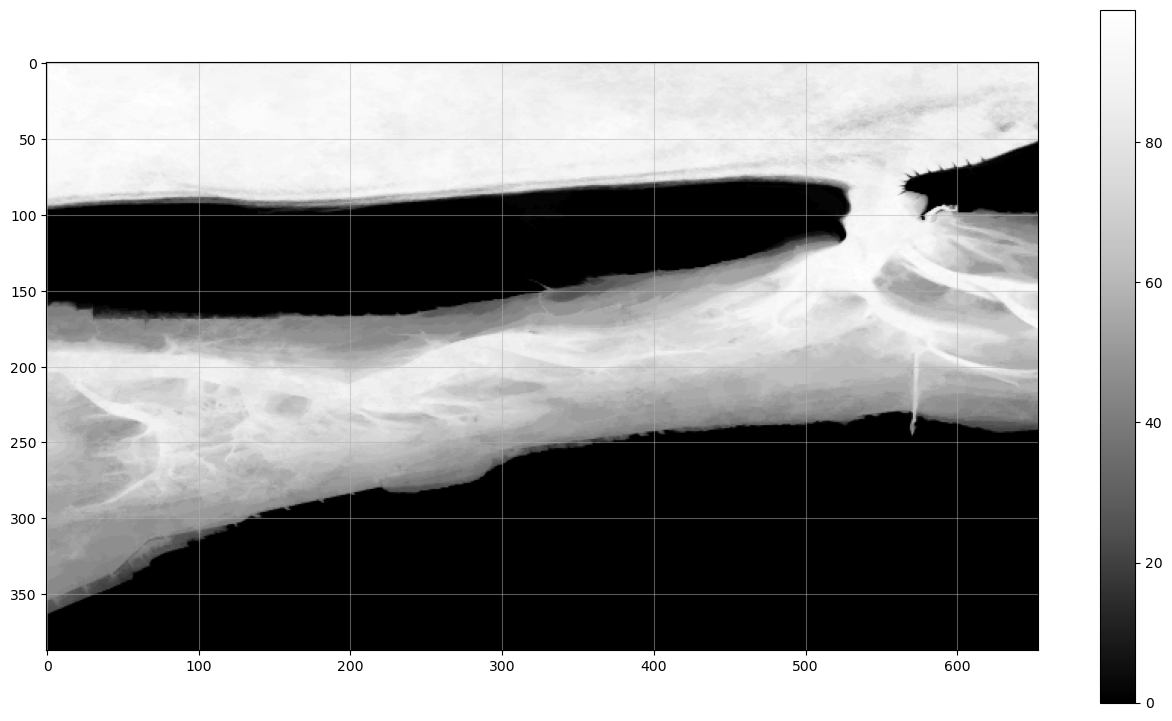

In [43]:
# plot data array
# TODO: note the blurryness, try to use the weights to get rid of it (clouds)
plt.figure(figsize=(16,9))
plt.imshow(np_arr_ndwi2, cmap="Greys_r")#vmin=-0.05, vmax=0.15
plt.grid(alpha=0.5)
# plt.clim(0,1)
plt.colorbar()
plt.show()

In [18]:
# get array and check values
#band_arrs_ndwi = ndwi.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
# band_arrs_ndwi = NDWICollection.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arrs_ndwi = NDWICollectionMapped.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
#band_arrs_ndwi = gridCellWaterOccurrenceOutput.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arr_ndwi = band_arrs_ndwi.get('weight')
np_arr_ndwi2 = np.array(band_arr_ndwi.getInfo())
print(np_arr_ndwi2.shape)
print(np_arr_ndwi2)

(387, 654)
[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 0.99959992 0.99297533 0.98671171]
 [1.         1.         1.         ... 0.98081599 0.97406365 0.96767763]
 ...
 [0.10198039 0.08246211 0.06324555 ... 0.35777088 0.34928498 0.34176015]
 [0.1077033  0.08944272 0.07211103 ... 0.37576588 0.36769553 0.36055513]
 [0.11661904 0.1        0.08246211 ... 0.39395431 0.38626416 0.37947332]]


In [ ]:
np.max(np_arr_ndwi2)

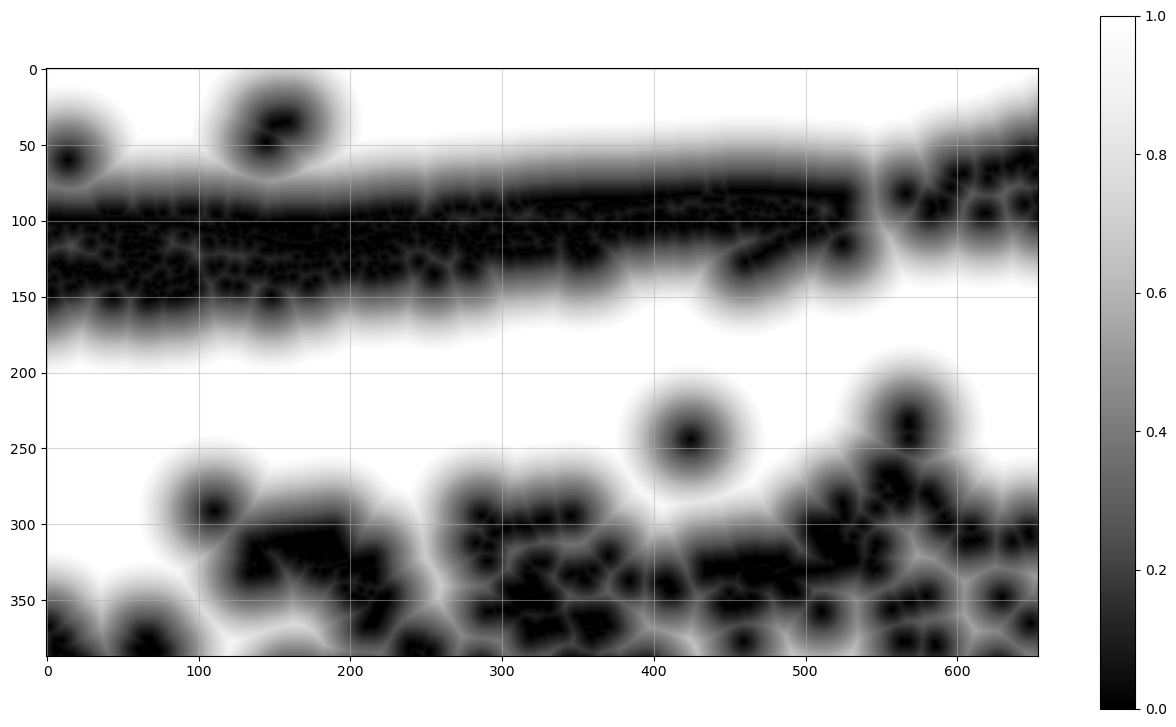

In [19]:
# plot data array
# TODO: note the blurryness, try to use the weights to get rid of it (clouds)
plt.figure(figsize=(16,9))
plt.imshow(np_arr_ndwi2, cmap="Greys_r")#vmin=-0.05, vmax=0.15
plt.grid(alpha=0.5)
# plt.clim(0,1)
plt.colorbar()
plt.show()

In [20]:
# get array and check values
#band_arrs_ndwi = ndwi.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
# band_arrs_ndwi = NDWICollection.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arrs_ndwi = NDWICollectionMapped.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
#band_arrs_ndwi = gridCellWaterOccurrenceOutput.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arr_ndwi = band_arrs_ndwi.get('ndwi_waterweight')
np_arr_ndwi2 = np.array(band_arr_ndwi.getInfo())
print(np_arr_ndwi2.shape)
print(np_arr_ndwi2)

(387, 654)
[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 0.99959992 0.99297533 0.98671171]
 [1.         1.         1.         ... 0.98081599 0.97406365 0.96767763]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


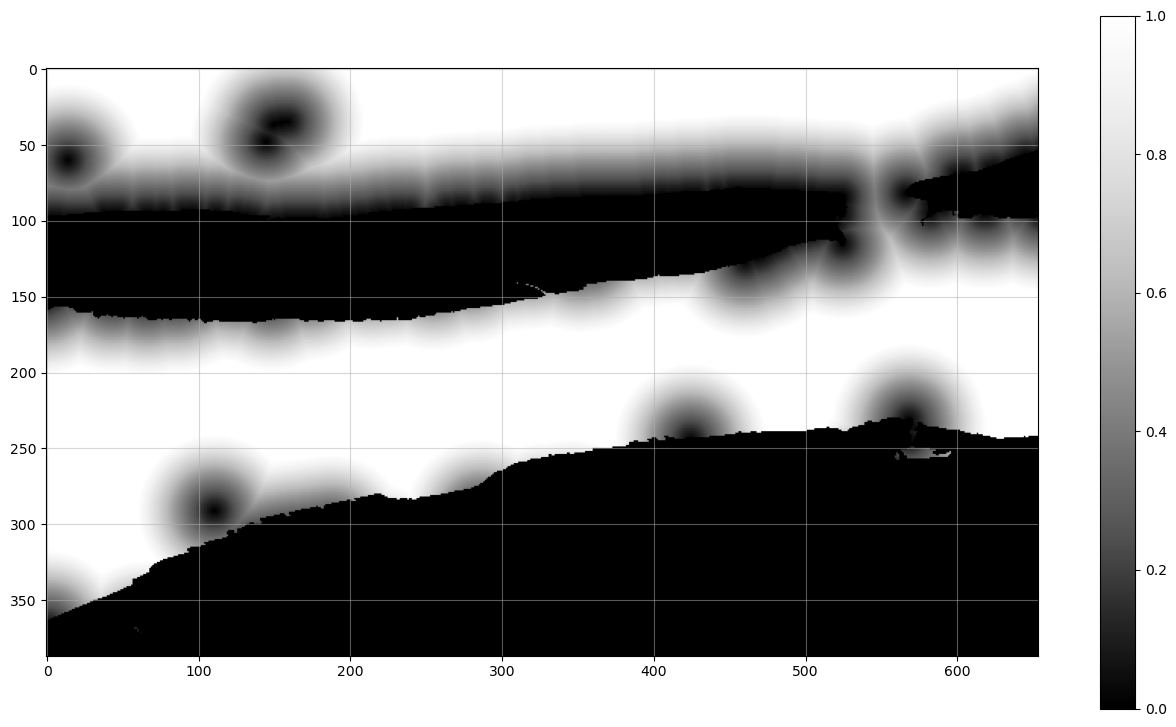

In [21]:
# plot data array
# TODO: note the blurryness, try to use the weights to get rid of it (clouds)
plt.figure(figsize=(16,9))
plt.imshow(np_arr_ndwi2, cmap="Greys_r")#vmin=-0.05, vmax=0.15
plt.grid(alpha=0.5)
# plt.clim(0,1)
plt.colorbar()
plt.show()

In [76]:
gridCellWaterOccurrenceOutput.getInfo()

{'type': 'Image',
 'bands': [{'id': 'waterOccurrencePercentage',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': -32443.568359375,
    'max': 32442.576171875},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'waterOccurrenceCount',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': -32768,
    'max': 32767},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'numberOfImagesAnalysed',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [58]:
# get array and check values
#band_arrs_ndwi = ndwi.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
# band_arrs_ndwi = NDWICollection.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
#band_arrs_ndwi = NDWICollectionMapped.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arrs_ndwi = gridCellWaterOccurrenceOutput.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arr_ndwi = band_arrs_ndwi.get('ndwiMedian')
np_arr_ndwi2 = np.array(band_arr_ndwi.getInfo())
print(np_arr_ndwi2.shape)
print(np_arr_ndwi2)

EEException: User memory limit exceeded.

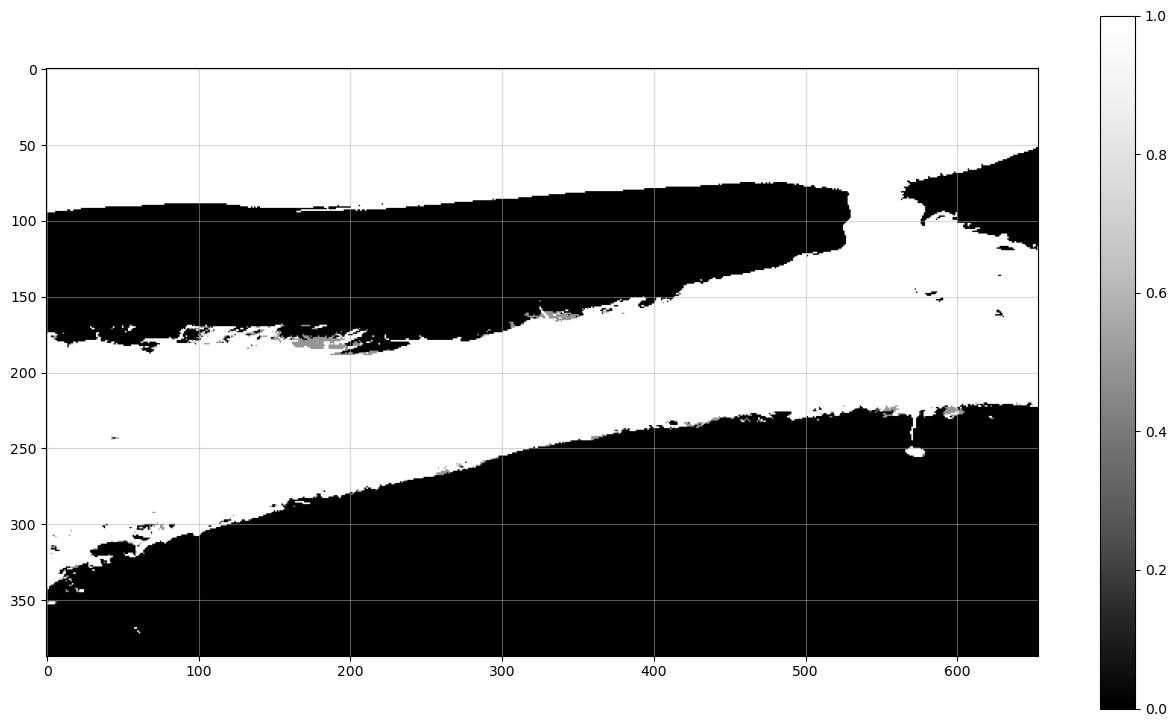

In [87]:
# plot data array
# TODO: note the blurryness, try to use the weights to get rid of it (clouds)
plt.figure(figsize=(16,9))
plt.imshow(np_arr_ndwi2, cmap="Greys_r")#vmin=-0.05, vmax=0.15
plt.grid(alpha=0.5)
# plt.clim(0,1)
plt.colorbar()
plt.show()

In [57]:
# get array and check values
#band_arrs_ndwi = ndwi.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
# band_arrs_ndwi = NDWICollection.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
#band_arrs_ndwi = NDWICollectionMapped.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arrs_ndwi = gridCellWaterOccurrenceOutput.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arr_ndwi = band_arrs_ndwi.get('waterOccurrencePercentage')
np_arr_ndwi = np.array(band_arr_ndwi.getInfo())
print(np_arr_ndwi.shape)
print(np_arr_ndwi)

EEException: User memory limit exceeded.

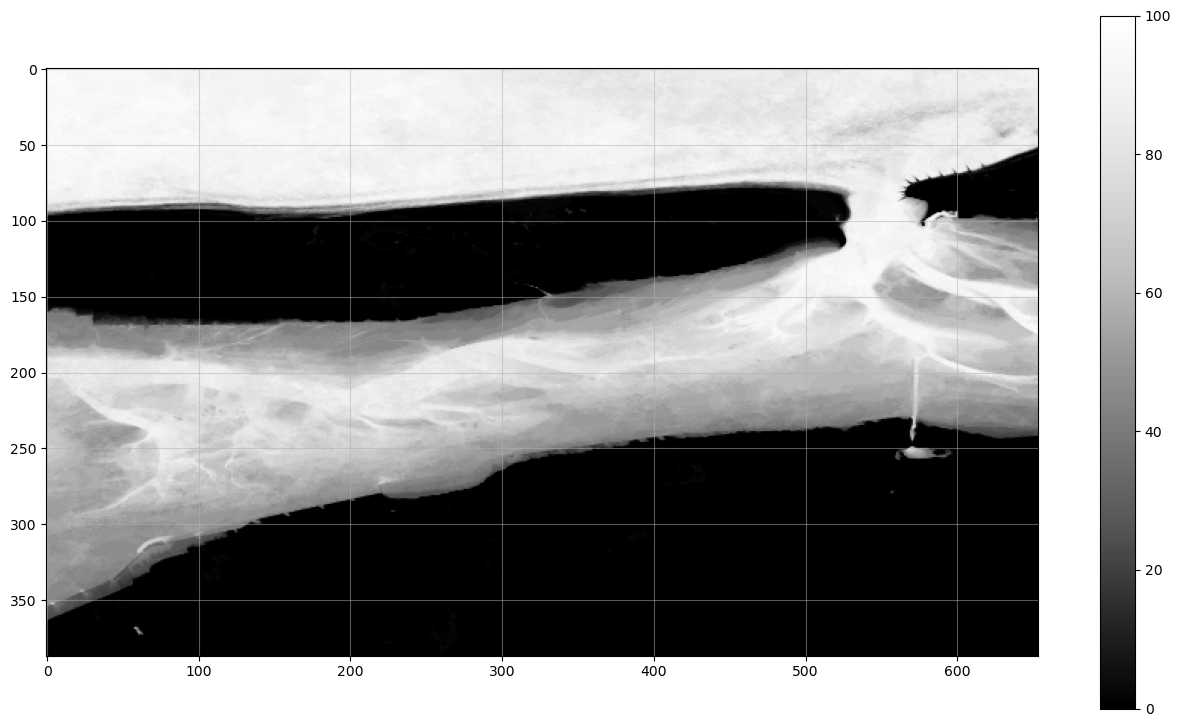

In [24]:
# plot data array
plt.figure(figsize=(16,9))
plt.imshow(np_arr_ndwi, vmin=0, vmax=100, cmap="Greys_r")#vmin=-0.05, vmax=0.15
plt.grid(alpha=0.5)
# plt.clim(0,1)
plt.colorbar()
plt.show()

In [17]:
# note, scale was adjusted as the original scale was too high for the sampleRectangle function (memory limits as GEE was overcrowed)
band_arrs_ndwi = waterPercentageWeighted.reproject(crs = ee.Projection('EPSG:4326'), scale=120).sampleRectangle(region=bounds)
band_arr_ndwi = band_arrs_ndwi.get('waterOccurrencePercentageWeighted')
np_arr_ndwi2 = np.array(band_arr_ndwi.getInfo())
print(np_arr_ndwi2.shape)
print(np_arr_ndwi2)

In [ ]:
band_arrs_ndwi = waterPercentageWeighted.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arr_ndwi = band_arrs_ndwi.get('waterOccurrencePercentageWeighted')
np_arr_ndwi = np.array(band_arr_ndwi.getInfo())
print(np_arr_ndwi.shape)
print(np_arr_ndwi)

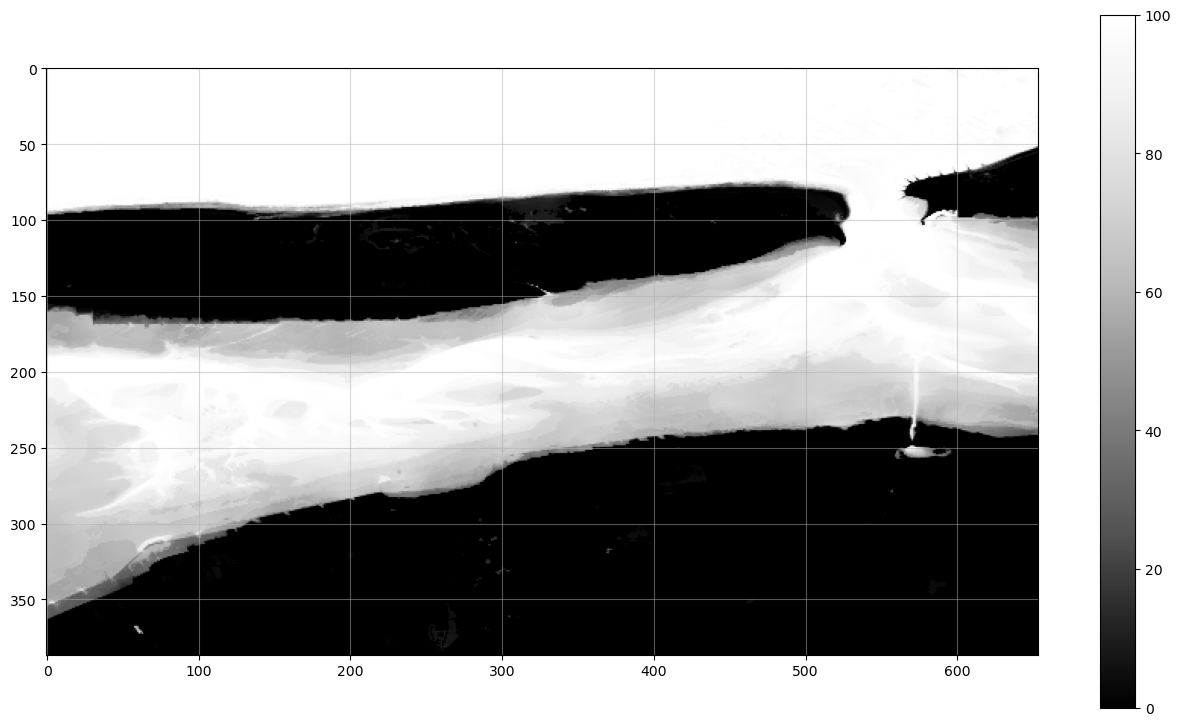

In [ ]:
# plot data array
# TODO: note the blurryness, try to use the weights to get rid of it (clouds)
plt.figure(figsize=(16,9))
plt.imshow(np_arr_ndwi2, cmap="Greys_r")#vmin=-0.05, vmax=0.15
plt.grid(alpha=0.5)
# plt.clim(0,1)
plt.colorbar()
plt.show()

In [25]:
# get array and check values
#band_arrs_ndwi = ndwi.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
# band_arrs_ndwi = NDWICollection.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arrs_ndwi = NDWICollectionMapped.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
#band_arrs_ndwi = gridCellWaterOccurrenceOutput.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arr_ndwi = band_arrs_ndwi.get('ndwi_water')
np_arr_ndwi2 = np.array(band_arr_ndwi.getInfo())
print(np_arr_ndwi2.shape)
print(np_arr_ndwi2)

(387, 654)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


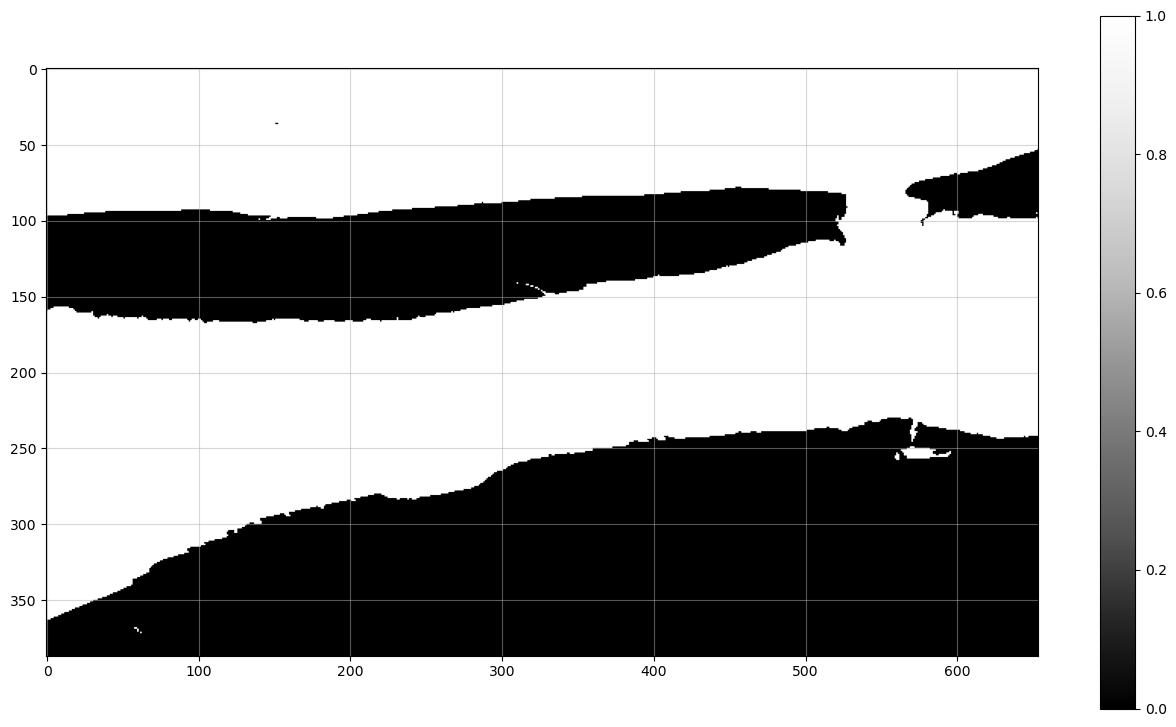

In [26]:
# plot data array
plt.figure(figsize=(16,9))
plt.imshow(np_arr_ndwi2, vmin=0, vmax=1, cmap="Greys_r")#vmin=-0.05, vmax=0.15
plt.grid(alpha=0.5)
# plt.clim(0,1)
plt.colorbar()
plt.show()

In [49]:
band_arrs = sdb._images_with_statistics.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arr_ndwi = band_arrs.get('ndwi')
np_arr_ndwi = np.array(band_arr_ndwi.getInfo())
print(np_arr_ndwi.shape)
print(np_arr_ndwi)

(387, 654)
[[ 0.15000001  0.15000001  0.15000001 ...  0.15000001  0.15000001
   0.15000001]
 [ 0.15000001  0.15000001  0.15000001 ...  0.15000001  0.15000001
   0.15000001]
 [ 0.15000001  0.15000001  0.15000001 ...  0.15000001  0.15000001
   0.15000001]
 ...
 [-0.05       -0.05       -0.05       ... -0.05       -0.05
  -0.05      ]
 [-0.05       -0.05       -0.05       ... -0.05       -0.05
  -0.05      ]
 [-0.05       -0.05       -0.05       ... -0.05       -0.05
  -0.05      ]]


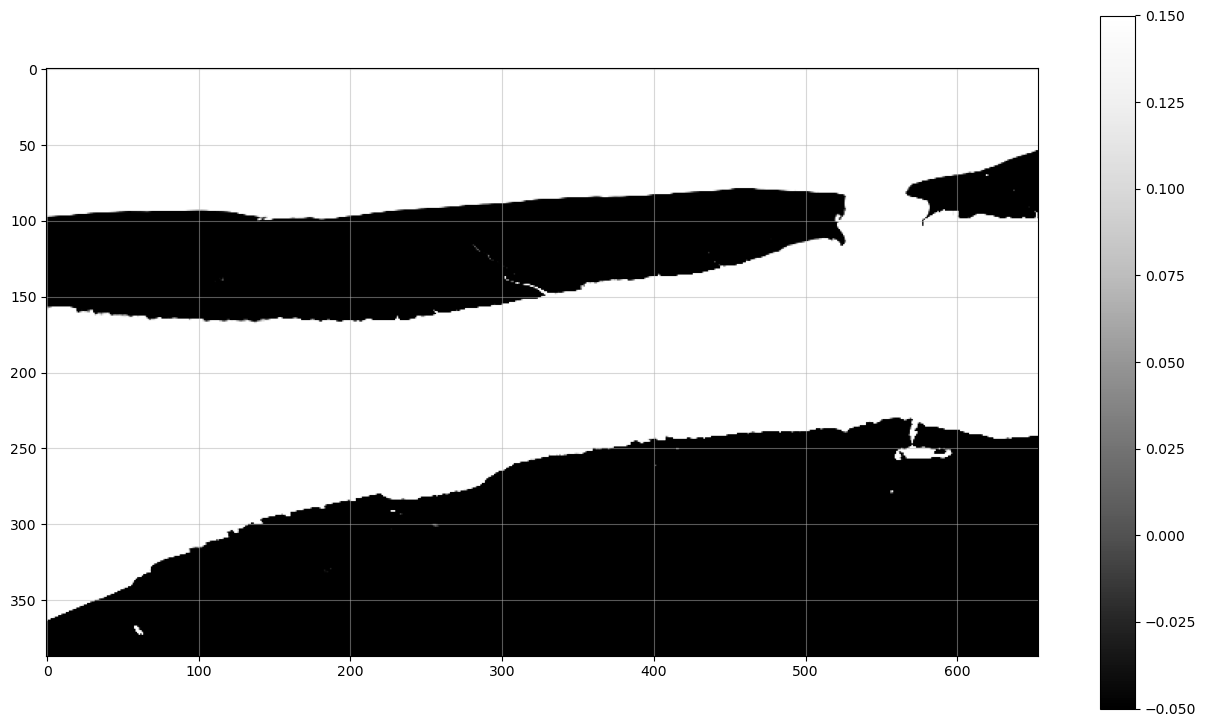

In [52]:
plt.figure(figsize=(16,9))
plt.imshow(np_arr_ndwi, vmin=-0.05, vmax=0.15, cmap="Greys_r")
plt.grid(alpha=0.5)
# plt.clim(0,1)
plt.colorbar()
plt.show()

In [ ]:
band_arrs = image.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arr_ndwi = band_arrs.get('ndwi')
np_arr_ndwi = np.array(band_arr_ndwi.getInfo())
print(np_arr_ndwi.shape)
print(np_arr_ndwi)

In [ ]:
plt.figure(figsize=(16,9))
plt.imshow(np_arr_ndwi, vmin=-0.05, vmax=0.15, cmap="Greys_r")
plt.grid(alpha=0.5)
# plt.clim(0,1)
plt.colorbar()
plt.show()

In [25]:
sdb._refined_images.getInfo()

{'type': 'ImageCollection',
 'bands': [],
 'features': [{'type': 'Image',
   'bands': [{'id': 'swir',
     'data_type': {'type': 'PixelType', 'precision': 'float'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]},
    {'id': 'nir',
     'data_type': {'type': 'PixelType', 'precision': 'float'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]},
    {'id': 'red',
     'data_type': {'type': 'PixelType', 'precision': 'float'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]},
    {'id': 'green',
     'data_type': {'type': 'PixelType', 'precision': 'float'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]},
    {'id': 'blue',
     'data_type': {'type': 'PixelType', 'precision': 'float'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]},
    {'id': 'q',
     'data_type': {'type': 'PixelType', 'precision': 'float'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]},
    {'id': 'weight',


In [ ]:
# interactive plotter

In [36]:
# Plot all raw images
Map = geemap.Map()
Map.centerObject(bounds, 9)
Map.addLayer(bounds, {}, "AoI")
# from tqdm import tqdm
# for idx in tqdm(range(sdb._raw_images.size().getInfo())):
#     image_ = ee.Image(sdb._raw_images.toList(sdb._raw_images.size()).get(idx))
#     Map.addLayer(image_, {"bands": ["red", "green", "blue"], "min": 0, "max": 0.3}, f"image_{idx} (date: {dates[idx]})")
#     if idx > 1:
#         break
Map

Map(center=[53.696663843187544, 7.294921876971232], controls=(WidgetControl(options=['position', 'transparent_…

In [38]:
Map.addLayer(sdb._raw_images.first().clip(bounds), {"bands": ["red", "green", "blue"], "min": 0, "max": 0.3}, f"image_{idx} (date: {dates[idx]})")

In [ ]:
idx = 1
Map.addLayer(image.select("ndwi").clip(bounds), {"bands": ["ndwi"], "min": 0, "max": 1}, f"image_{idx} (date: {dates[idx]})")